## Import packages

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

## Task 1: implement Multi Head Attention

![Multi Head Attention](../labs/images/multi-head-attention.png)

In [2]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention module.

    This module performs multi-head attention on the input tensor `x`. It applies linear transformations
    to the input tensor to obtain query, key, and value tensors. Then, it calculates attention weights
    and applies attention to the value tensor. Finally, it applies another linear transformation to
    obtain the output tensor.

    Args:
        in_channels (int): Number of input channels.
        hidden_channels (int): Number of hidden channels.
        num_heads (int): Number of attention heads.
        out_channels (int, optional): Number of output channels. If not provided, it is set to `in_channels`.
        bias (bool, optional): Whether to include bias in linear transformations. Default is False.

    Returns:
        torch.Tensor: Output tensor of shape (batch_size, seq_len, in_channels).

    """

    def __init__(
        self, in_channels, hidden_channels, num_heads, out_channels=None, bias=False
    ):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.hidden_channels = hidden_channels
        self.in_channels = in_channels

        self.W_q = nn.Linear(in_channels, num_heads * hidden_channels, bias=bias)
        self.W_k = nn.Linear(in_channels, num_heads * hidden_channels, bias=bias)
        self.W_v = nn.Linear(in_channels, num_heads * hidden_channels, bias=bias)
        self.W_o = nn.Linear(
            num_heads * hidden_channels,
            in_channels if out_channels is None else out_channels,
        )

        self.scale = 1.0 / math.sqrt(hidden_channels)

    def forward(self, x):
        # x.shape = (batch_size, seq_len, in_channels)

        B = x.shape[0]
        N = x.shape[1]

        """
        insert the missing codes here
        """
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        # reshape
        Q = Q.view(B, self.num_heads, N, self.hidden_channels)
        K = K.view(B, self.num_heads, N, self.hidden_channels)
        V = V.view(B, self.num_heads, N, self.hidden_channels)

        # calculate attention
        """
        Hint: you need to transpose the last two dimensions of K before you can multiply it with Q to get the attention logits.
        """
        attn_logits = torch.matmul(Q, K.transpose(-2, -1))
        attn_logits *= self.scale
        attn_weights = F.softmax(attn_logits, dim=-1)
        # attn_weights.shape: (B, num_heads, N, N)

        # apply attention
        mha_output = torch.matmul(attn_weights, V)
        # mha_output.shape: (B, num_heads, N, hidden_channels)

        # reshape
        mha_output = mha_output.view(B, N, self.hidden_channels * self.num_heads)
        # mha_output.shape: (B, N, hidden_channels * num_heads)

        mha_output = self.W_o(mha_output)
        # mha_output.shape: (B, N, in_channels)

        return mha_output

In [3]:
mha = MultiHeadAttention(32, 32, 4)
x = torch.rand(2, 5, 32)
output = mha(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([2, 5, 32])
Output shape: torch.Size([2, 5, 32])


## Composing the Transformer Block

![Transformer encoder](../labs/images/transformer-encoder.png)

In [4]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(FeedForwardNetwork, self).__init__()
        self.ff = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels),
        )

    def forward(self, x):
        return self.ff(x)


class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads):
        super(TransformerBlock, self).__init__()
        hidden_channels = d_model // num_heads
        self.mha = MultiHeadAttention(d_model, hidden_channels, num_heads)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = FeedForwardNetwork(d_model, d_model * 4, d_model)

    def forward(self, x):
        mha_output = self.mha(x)
        x = self.ln1(x + mha_output)
        ffn_output = self.ffn(x)
        x = self.ln2(x + ffn_output)
        return x

In [5]:
transformer_block = TransformerBlock(32, 4)
x = torch.rand(2, 5, 32)
output = transformer_block(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([2, 5, 32])
Output shape: torch.Size([2, 5, 32])


## Task 2: define the Transformer Encoder

In [6]:
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, num_heads, num_layers=1):
        super(TransformerEncoder, self).__init__()
        self.layers = nn.ModuleList(
            [TransformerBlock(d_model, num_heads) for _ in range(num_layers)]
        )

    def forward(self, x):
        # x.shape = (batch_size, seq_len, d_model)
        for layer in self.layers:
            x = layer(x)
        return x

## Task 3: build a Vision transformer
We build a slight variation from the model below, namely we stick to the original Transformer Block architecture and just a single linear layer to project the output of the transformer to the number of classes.

![ViT](../labs/images/vit-overview.png)

In [7]:
class VisionTransformer(nn.Module):
    def __init__(
        self, in_channels, d_model, num_heads, num_classes, n_patches, num_layers=1
    ):
        super(VisionTransformer, self).__init__()
        # positional embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, n_patches + 1, d_model) * 0.02)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.encoder = TransformerEncoder(d_model, num_heads, num_layers)
        self.fc_in = nn.Linear(in_channels, d_model)
        self.fc_out = nn.Linear(d_model, num_classes)

    def forward(self, x):
        """
        fill in the blanks here
        """
        # x.shape = (batch_size, n_patches, in_channels)
        B, N, C = x.shape
        x = self.fc_in(x)  # (B, N, C) -> (B, N, d_model)
        cls_tokens = self.cls_token.expand(
            B, -1, -1
        )  # (1, 1, d_model) -> (B, 1, d_model)

        # concatenate the cls token with the input
        x = torch.cat((cls_tokens, x), dim=1)

        # add the positonal embeddings
        x += self.pos_embedding  # (B, N+1, d_model)

        # apply the encoder
        x = self.encoder(x)  # (B, N+1, d_model)
        # extract the cls token
        x = x[:, 0]  # (B, d_model)

        x = self.fc_out(x)  # (B, num_classes)
        return x

## Train the Vision Transformer on MNIST dataset

In [8]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

# Load MNIST dataset
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

# reduce the size of the dataset for faster training
train_dataset.data = train_dataset.data[:1000]
train_dataset.targets = train_dataset.targets[:1000]

test_dataset.data = test_dataset.data[:100]
test_dataset.targets = test_dataset.targets[:100]

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5837690.58it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 232536.03it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:12<00:00, 128685.68it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2232571.05it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
def patchify_img(img, patch_size=7):
    c, h, w = img.shape
    assert h / patch_size == h // patch_size, "height must be divisible by patch size"
    assert w / patch_size == w // patch_size, "width must be divisible by patch size"
    patches = img.reshape(c, h // patch_size, patch_size, -1, patch_size)
    patches = patches.permute(0, 1, 3, 2, 4).reshape(-1, patch_size, patch_size)
    return patches


class PatchifyDataset(Dataset):
    def __init__(self, dataset, patch_size):
        self.dataset = dataset
        self.patch_size = patch_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        patches = patchify_img(img, self.patch_size)
        # flatten the last dim
        patches = patches.view(patches.size(0), -1)
        return patches, label

In [10]:
batch_size = 32
n_epochs = 50
patch_size = 7
num_layers = 1
num_heads = 4
seed = 42

torch.manual_seed(seed)

train_dataset_patched = PatchifyDataset(train_dataset, patch_size=patch_size)
test_dataset_patched = PatchifyDataset(test_dataset, patch_size=patch_size)

train_loader = DataLoader(train_dataset_patched, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset_patched, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

model = VisionTransformer(
    in_channels=patch_size**2,
    d_model=32,
    num_heads=num_heads,
    num_classes=10,
    n_patches=16,
    num_layers=num_layers,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    running_train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    running_train_loss /= len(train_loader)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            val_loss = criterion(y_pred, y)
            running_val_loss += val_loss.item()
        running_val_loss /= len(test_loader)

    print(
        f"Epoch {epoch}, Train loss: {running_train_loss}, Val. loss: {running_val_loss}"
    )
    train_losses.append(running_train_loss)
    val_losses.append(running_val_loss)

Using cpu
Epoch 0, Train loss: 2.1954911909997463, Val. loss: 1.9341664612293243
Epoch 1, Train loss: 1.8509266898036003, Val. loss: 1.538341373205185
Epoch 2, Train loss: 1.712977096438408, Val. loss: 1.447629451751709
Epoch 3, Train loss: 1.6089960783720016, Val. loss: 1.3338679075241089
Epoch 4, Train loss: 1.5326409675180912, Val. loss: 1.217434585094452
Epoch 5, Train loss: 1.4615035653114319, Val. loss: 1.1510196924209595
Epoch 6, Train loss: 1.3826995119452477, Val. loss: 1.1598309874534607
Epoch 7, Train loss: 1.386367093771696, Val. loss: 1.146871656179428
Epoch 8, Train loss: 1.3531720228493214, Val. loss: 1.1239045560359955
Epoch 9, Train loss: 1.3576050363481045, Val. loss: 1.1051425486803055
Epoch 10, Train loss: 1.3012544494122267, Val. loss: 1.1214271783828735
Epoch 11, Train loss: 1.2903078384697437, Val. loss: 1.062792420387268
Epoch 12, Train loss: 1.3005055338144302, Val. loss: 1.09966579079628
Epoch 13, Train loss: 1.2861209157854319, Val. loss: 1.1920525282621384
E

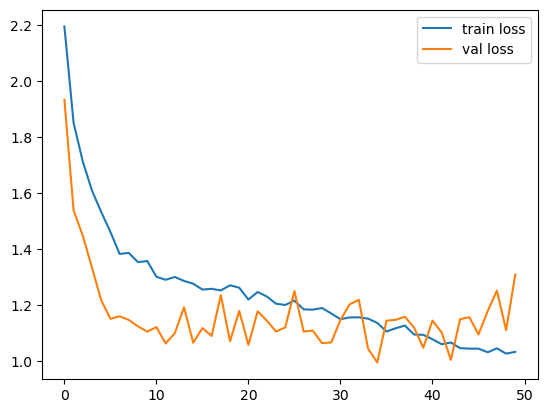

In [11]:
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend()
plt.show()

## Bonus: apply the model on the full test set, visualize some results and compute the accuracy

## Further reading/watching

1. [GPT from scratch by Andrey Karpathy](https://www.youtube.com/watch?v=kCc8FmEb1nY), his other videos are also extremely informative